In [5]:
## for google colab use only
!pip install uproot awkward mpl_scatter_density jupyter-dash
from google.colab import drive
drive.mount('/content/drive')

In [19]:
import uproot, scipy, math, os, random, time, pickle, collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist

# Import Data

In [20]:
# emutxt = pd.read_csv("/content/drive/MyDrive/ForAli/chk_trks_genie_200003_s0007_10files_p761-770.txt", sep='\s+', header=None)
emutxt = pd.read_csv("emulsion_data/chk_trks_genie_200003_s0007_10files-1-10_p761-770_MC_neutrino.txt", sep='\s+', header=None)

emutxt.columns = ["t->ID", "plate_first", "plate_last", "x1", "y1", "z1", "x", "y", "z", 
               'tx1', 'ty1', "txlast", "tylast", "tx", "ty", "t->N()", "t->Npl()", "eventID", "pdgID", "momentum"]
emutxt = emutxt[emutxt["plate_last"] > 768] # save last two layers
emutxt.eventID = emutxt.eventID - 100000
emutxt

,t->ID,plate_first,plate_last,x1,y1,z1,x,y,z,tx1,ty1,txlast,tylast,tx,ty,t->N(),t->Npl(),eventID,pdgID,momentum
0,0,761,770,-66167.3,95469.2,1026140.0,-66030.4,95065.2,1038290.1,0.010369,-0.032536,0.011744,-0.033252,0.011267,-0.033248,10,10,2005,211,19.17
1,1,761,770,-59255.1,84340.7,1026140.0,-57808.4,82041.4,1038290.1,0.123982,-0.181864,0.124275,-0.180986,0.119072,-0.189240,9,10,2005,211,1.65
2,2,761,770,-64571.0,100041.3,1026140.0,-64208.6,100327.4,1038290.1,0.029841,0.021652,0.030727,0.024464,0.029829,0.023550,10,10,2005,-321,11.47
3,3,761,770,-4225.8,-80118.5,1026140.0,-4187.7,-79875.6,1038290.1,0.002926,0.014286,0.005644,0.020066,0.003143,0.019987,8,10,2019,-211,12.01
4,4,761,770,-2601.5,-77231.1,1026140.0,-2291.3,-76692.7,1038290.1,0.025488,0.042913,0.025390,0.044290,0.025531,0.044315,10,10,2019,-211,25.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,11749,764,770,-57505.4,133656.6,1030189.9,-57609.8,133685.9,1038290.1,-0.024135,0.014062,-0.012665,0.002566,-0.012888,0.003625,5,7,8520,-11,0.30
3411,11777,762,770,44657.9,20299.4,1027490.0,44712.2,20303.4,1038290.1,0.015416,-0.012946,0.005133,0.008132,0.005033,0.000370,7,9,20603,-11,143.68
3412,11811,765,769,79675.7,85087.8,1031540.1,79709.9,85151.8,1036939.9,-0.006391,0.010521,0.009152,0.005525,0.006344,0.011868,5,5,17718,11,0.80
3413,11821,762,770,-123404.4,-121151.3,1027490.0,-123322.3,-121077.5,1038290.1,0.006975,0.004297,0.016522,0.025368,0.007602,0.006833,9,9,21259,11,49.73


In [21]:
# Convert global coordinate
pl = np.array(emutxt['plate_last'])
z_tmp = np.where(pl == 770, -1950.27, np.where(pl == 769, -1951.63, np.nan))


emu = pd.DataFrame({
    'x': emutxt.x/1000 + 10, # convert um to mm and to global coordinate
    'y': emutxt.y/1000 - 21,
    'z': z_tmp,
    'tx': emutxt.tx,
    'ty': emutxt.ty,
    'eventID': emutxt.eventID,
    'pdgID': emutxt.pdgID
})
emu

,x,y,z,tx,ty,eventID,pdgID
0,-56.0304,74.0652,-1950.27,0.011267,-0.033248,2005,211
1,-47.8084,61.0414,-1950.27,0.119072,-0.189240,2005,211
2,-54.2086,79.3274,-1950.27,0.029829,0.023550,2005,-321
3,5.8123,-100.8756,-1950.27,0.003143,0.019987,2019,-211
4,7.7087,-97.6927,-1950.27,0.025531,0.044315,2019,-211
...,...,...,...,...,...,...,...
3410,-47.6098,112.6859,-1950.27,-0.012888,0.003625,8520,-11
3411,54.7122,-0.6966,-1950.27,0.005033,0.000370,20603,-11
3412,89.7099,64.1518,-1951.63,0.006344,0.011868,17718,11
3413,-113.3223,-142.0775,-1950.27,0.007602,0.006833,21259,11


In [22]:
# f = uproot.open('/content/drive/MyDrive/data/Collision/mc_ke_neutrinoMC.root')
f = uproot.open('emulsion_data/mc_ke_neutrinoMC.root')

f['tree'].show()

ift = f['tree'].arrays(['run_number',
                      'event_number',
                      'truthPdg',
                      'pTruthLepton',
                      'truthBarcode',
                      'ntruthmatchedclus',
                      'chi2',
                      'nclus0',
                      'nclus1',
                      'nclus2',
                      'nclus3',
                      'nclus',
                      'nsta',
                      'firstclus_x',
                      'firstclus_y',
                      'firstclus_z',
                      'lastclus_z',
                      'x',
                      'y',
                      'z',
                      'px',
                      'py',
                      'pz',
                      'p'], library='ak')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run_number           | int32_t                  | AsDtype('>i4')
event_number         | int32_t                  | AsDtype('>i4')
VetoNuPmt0           | double                   | AsDtype('>f8')
VetoNuPmt1           | double                   | AsDtype('>f8')
VetoPmt00            | double                   | AsDtype('>f8')
VetoPmt01            | double                   | AsDtype('>f8')
VetoUpstream         | double                   | AsDtype('>f8')
VetoPmt10            | double                   | AsDtype('>f8')
VetoPmt11            | double                   | AsDtype('>f8')
VetoDownstream       | double                   | AsDtype('>f8')
sta0nclus            | int32_t                  | AsDtype('>i4')
sta1nclus            | int32_t                  | AsDtype('>i4')
sta2nclus            | int32_t                  | AsDtype(

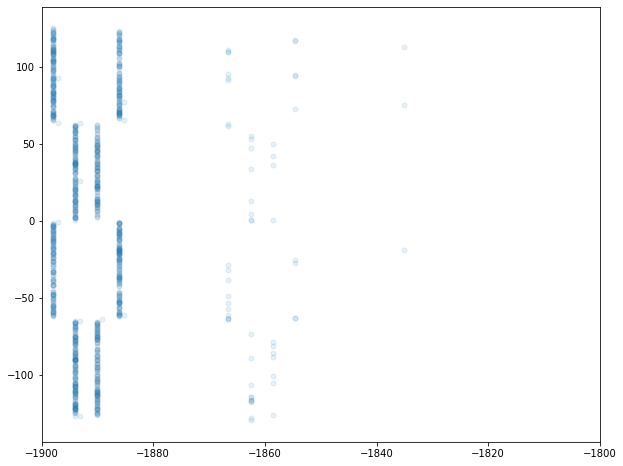

In [23]:
# plot truthPdg in ift 
plt.figure(figsize=(10, 8))
#make two 2 plot in one figure ift z vs ift x
plt.plot(ak.flatten(ift['z']), ak.flatten(ift['y']) , 'o', markersize=5, alpha=0.1)

# plt.hist(ak.flatten(ift['z']), bins=np.linspace(-1910, -1880, 511))

# x axis limit 
plt.xlim(-1900, -1800)
plt.show()

## Track Selection

In [24]:
track_loc = ak.where((ak.flatten(ift['chi2'])<30) & (ak.flatten(ift['z'])<-1875))
track_loc

(<Array [6, 14, 20, 23, ... 4737, 4740, 4743] type='920 * int64'>,)

In [25]:
# record event ID to check if a minimum chi2 track is truth matched
evt_tmp = []
num = ak.num(ift['z'])
for i in tqdm(range(len(ift['event_number']))):
    evt_tmp.append(list(ift['event_number'][i] * np.ones(num[i])))

ift_evt = ak.flatten(ak.Array(evt_tmp))[track_loc]


100%|██████████| 32000/32000 [00:08<00:00, 3652.66it/s]


In [26]:
iftx = ak.flatten(ift['x'])[track_loc]
ifty = ak.flatten(ift['y'])[track_loc]
iftz = ak.flatten(ift['z'])[track_loc]
ifttx = ak.flatten(ift['px'])[track_loc]/ak.flatten(ift['pz'])[track_loc]
iftty = ak.flatten(ift['py'])[track_loc]/ak.flatten(ift['pz'])[track_loc]

# Z position of module 4 and 6, which is largest z position in IFT 1st layer
module4_z = -1886.1353 # mm
def emu2ift(x, y, z, tx, ty):
    Dist_tot = np.abs(z - module4_z)
    x_pred = Dist_tot * tx + x
    y_pred = Dist_tot * ty + y
    return x_pred, y_pred

emu['x_pred'], emu['y_pred'] = emu2ift(emu['x'], emu['y'], emu['z'], emu['tx'], emu['ty'])

def ift2ift(x, y, z, tx, ty):
    Dist_tot = np.abs(z - module4_z)
    x_pred = Dist_tot * tx + x
    y_pred = Dist_tot * ty + y
    return x_pred, y_pred

ift_x_pred, ift_y_pred = ift2ift(iftx, ifty, iftz, ifttx, iftty)

'''
iftx_pred = iftx + (ak.flatten(ift['z'])[track_loc]+1898.05)*-ifttx
ifty_pred = ifty + (ak.flatten(ift['z'])[track_loc]+1898.05)*-iftty
emu['x_pred'] = emu.x + (-1898.05-emu.z+12.5)*emu.tx
emu['y_pred'] = emu.y + (-1898.05-emu.z+12.5)*emu.ty
'''

"\niftx_pred = iftx + (ak.flatten(ift['z'])[track_loc]+1898.05)*-ifttx\nifty_pred = ifty + (ak.flatten(ift['z'])[track_loc]+1898.05)*-iftty\nemu['x_pred'] = emu.x + (-1898.05-emu.z+12.5)*emu.tx\nemu['y_pred'] = emu.y + (-1898.05-emu.z+12.5)*emu.ty\n"

In [27]:
emu

,x,y,z,tx,ty,eventID,pdgID,x_pred,y_pred
0,-56.0304,74.0652,-1950.27,0.011267,-0.033248,2005,211,-55.307794,71.932849
1,-47.8084,61.0414,-1950.27,0.119072,-0.189240,2005,211,-40.171753,48.904549
2,-54.2086,79.3274,-1950.27,0.029829,0.023550,2005,-321,-52.295526,80.837772
3,5.8123,-100.8756,-1950.27,0.003143,0.019987,2019,-211,6.013875,-99.593740
4,7.7087,-97.6927,-1950.27,0.025531,0.044315,2019,-211,9.346123,-94.850571
...,...,...,...,...,...,...,...,...,...
3410,-47.6098,112.6859,-1950.27,-0.012888,0.003625,8520,-11,-48.436368,112.918388
3411,54.7122,-0.6966,-1950.27,0.005033,0.000370,20603,-11,55.034990,-0.672870
3412,89.7099,64.1518,-1951.63,0.006344,0.011868,17718,11,90.125398,64.929091
3413,-113.3223,-142.0775,-1950.27,0.007602,0.006833,21259,11,-112.834748,-141.639268


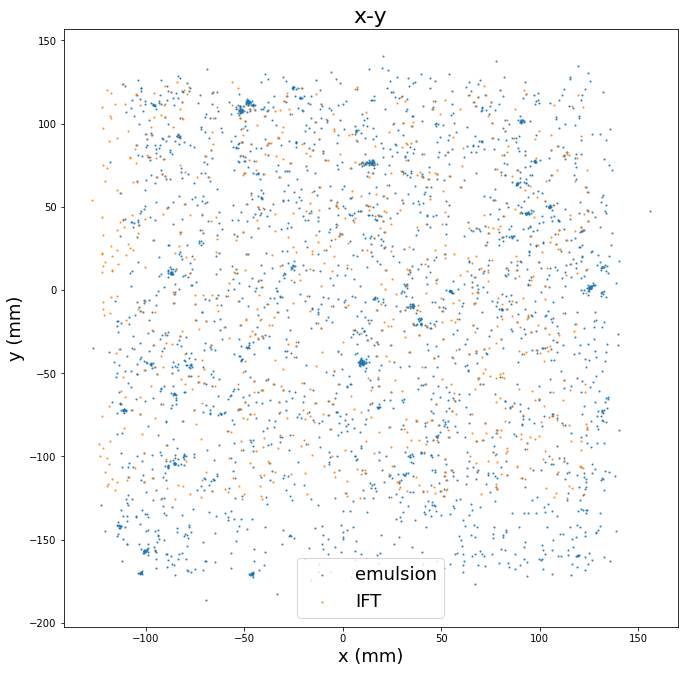

In [28]:
plt.figure(figsize=(11, 11))
plt.scatter(emu.x_pred, emu.y_pred, marker='.', s=5, alpha=0.8, label='emulsion')
plt.scatter(ift_x_pred, ift_y_pred, marker='.', s=5, alpha=0.8, label='IFT')
plt.xlabel(f'x (mm)', fontsize=18)
plt.ylabel(f'y (mm)', fontsize=18)
plt.title(f'x-y', fontsize=22)
plt.legend(fontsize=18)
plt.show()


NameError: name 'dx_tmp' is not defined

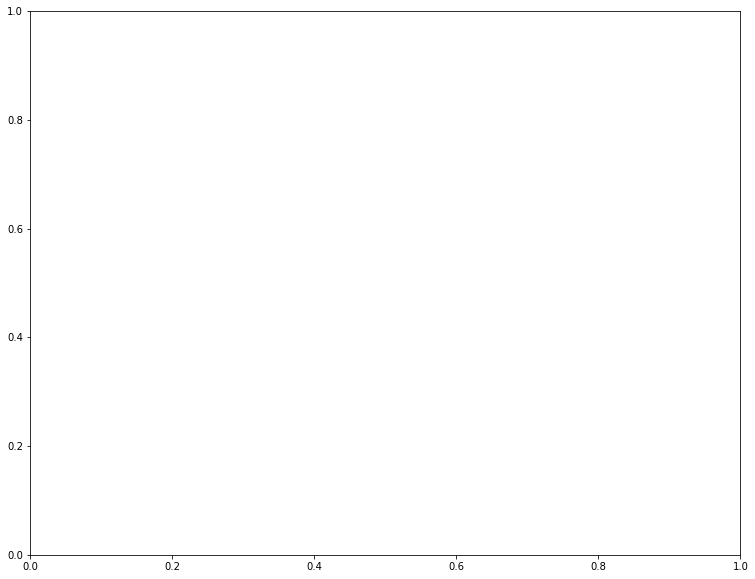

In [29]:
plt.figure(figsize=(28, 10))
plt.subplot(1, 2, 1)
bin = np.linspace(-5, 5, 71)
plt.hist(dx_tmp, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple', label=f'minimum chi2 dx µ: {round(np.mean(dx_tmp), 3)}, σ: {round(np.std(dx_tmp), 3)}')
plt.title('Residual x', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('dx (mm)', fontsize=20)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
bin = np.linspace(-0.25, 0.25, 71)
plt.hist(dy_tmp, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple', label=f'minimum chi2 dy µ: {round(np.mean(dy_tmp), 3)}, σ: {round(np.std(dy_tmp), 3)}')
plt.title('Residual y', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('dy (mm)', fontsize=20)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

# All Combinatorial Residual Search

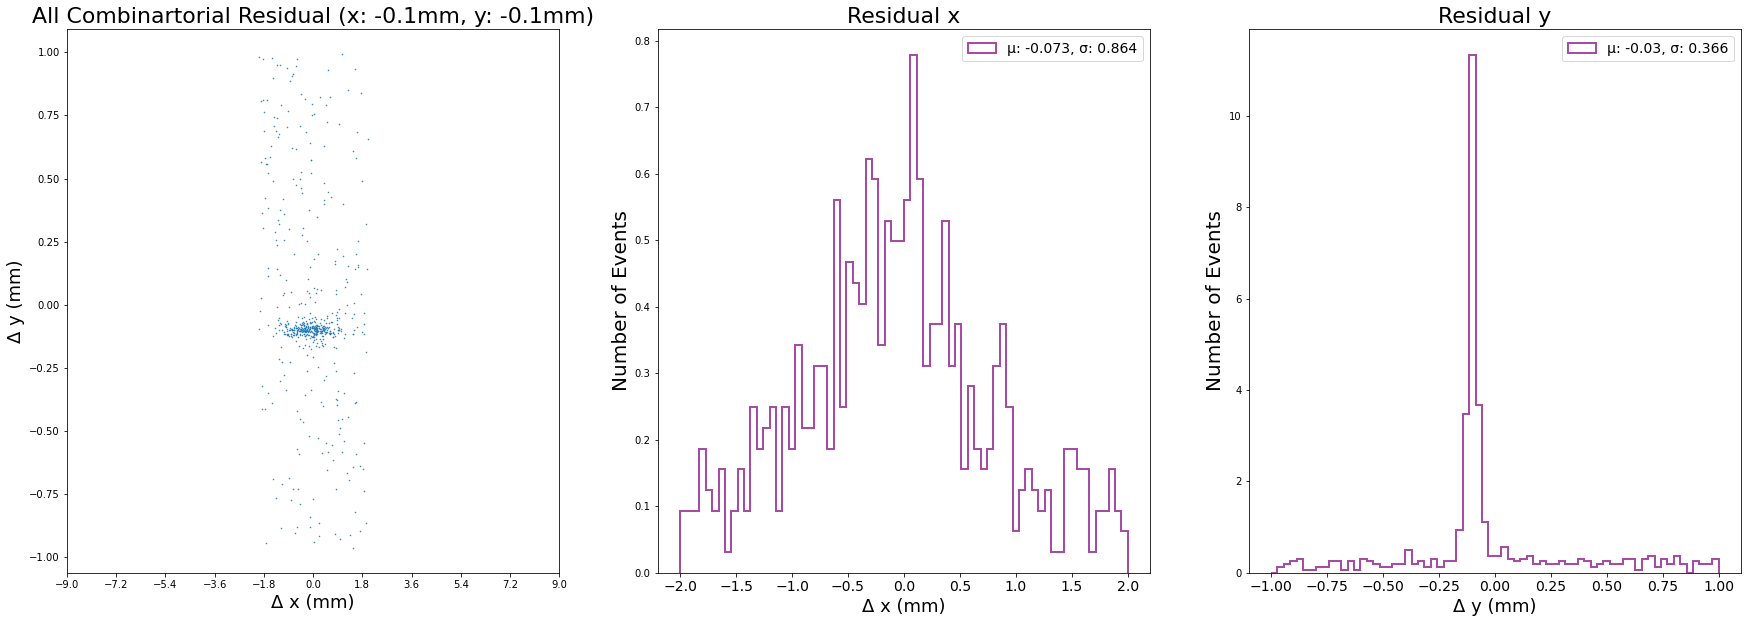

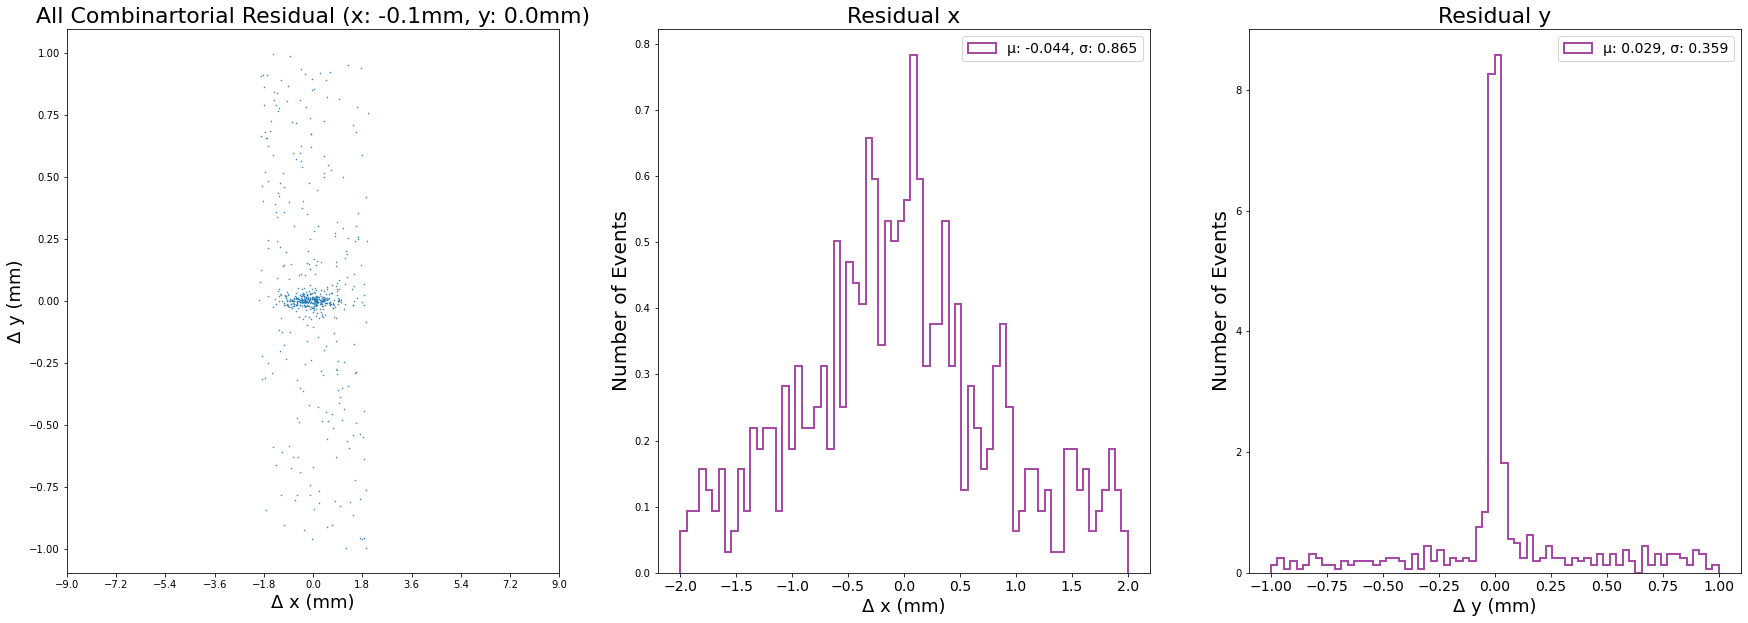

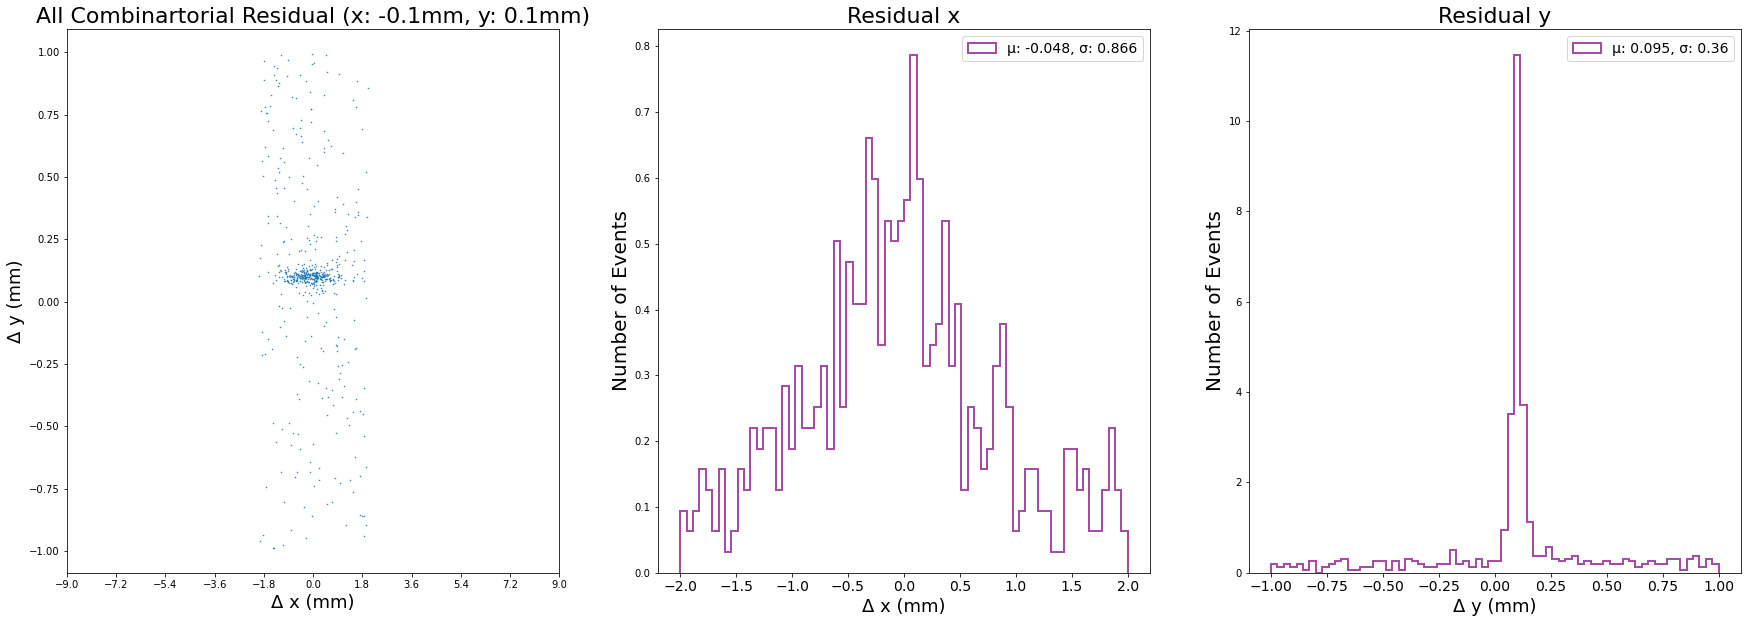

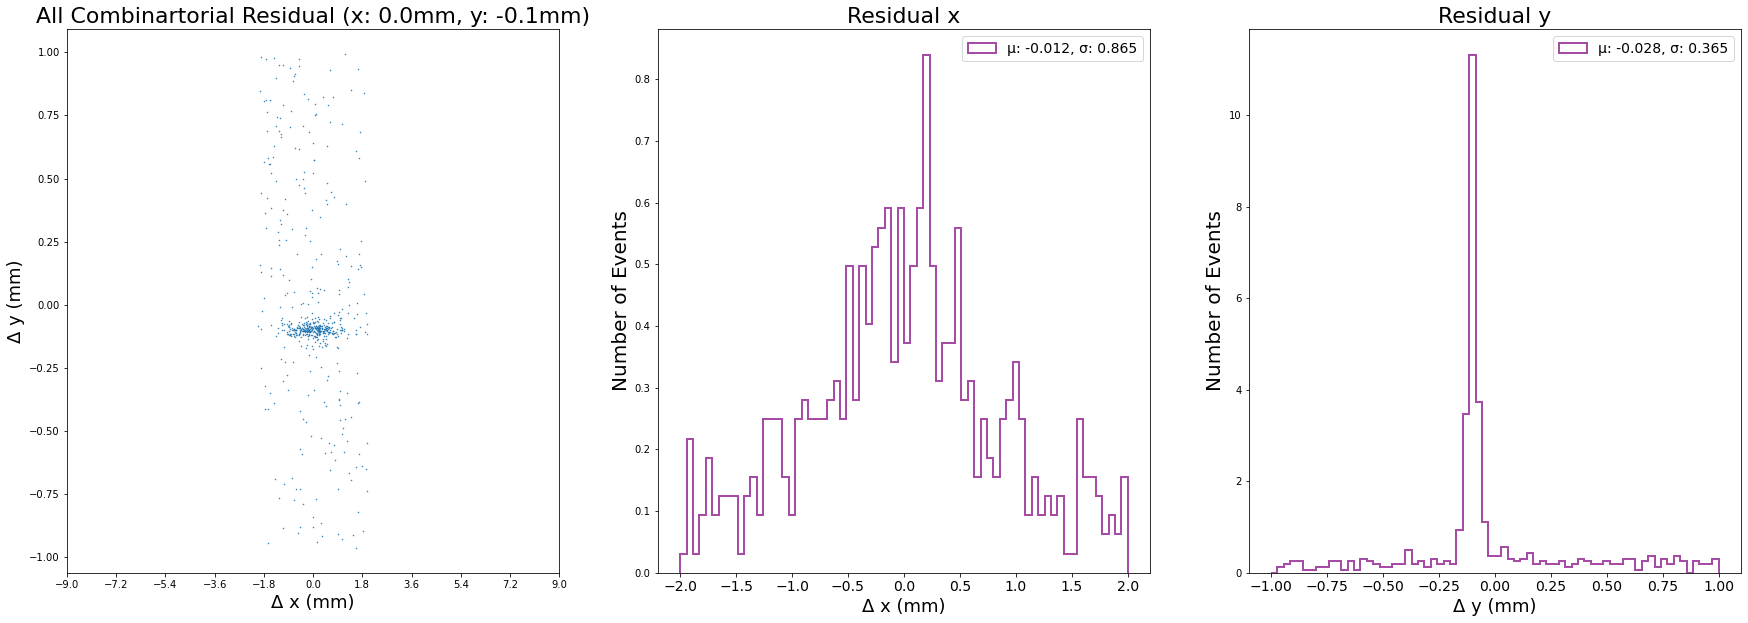

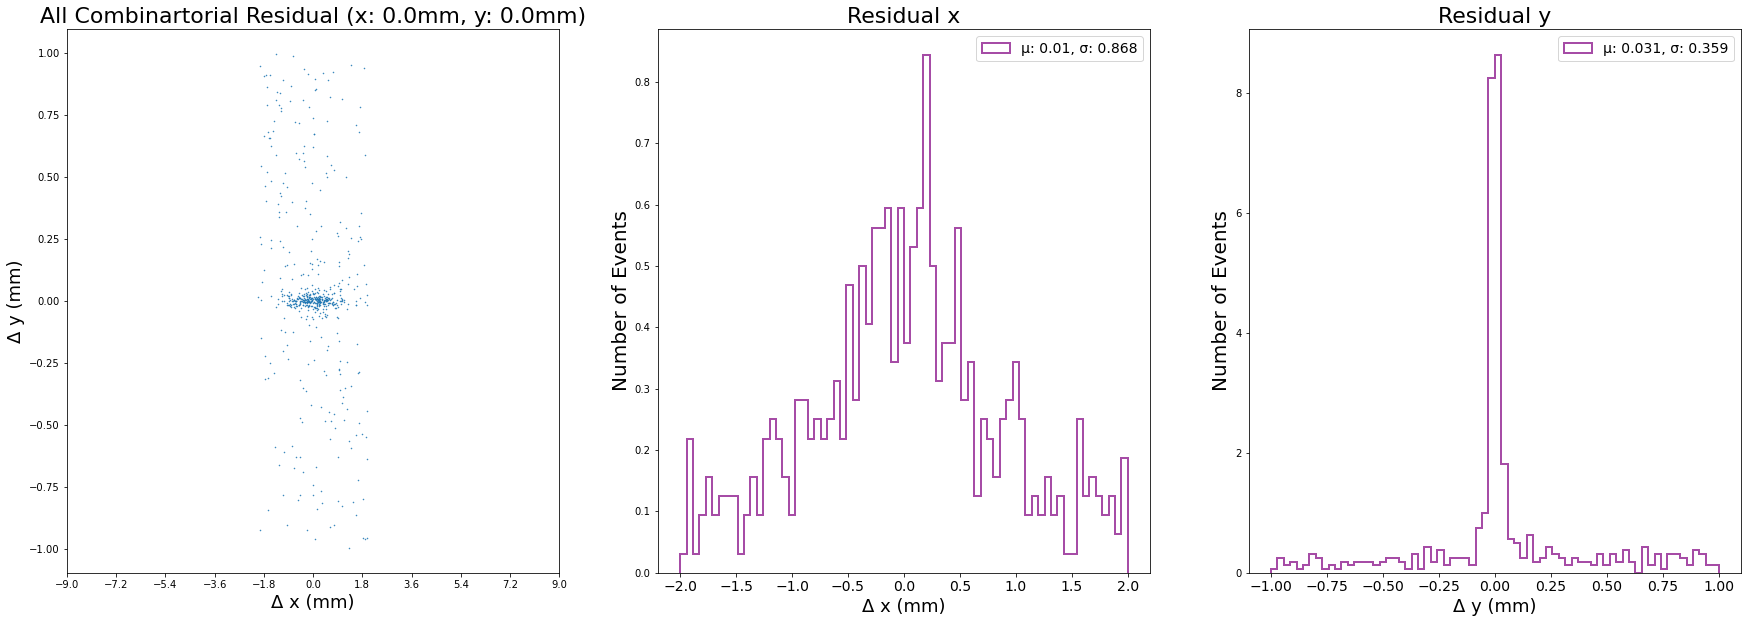

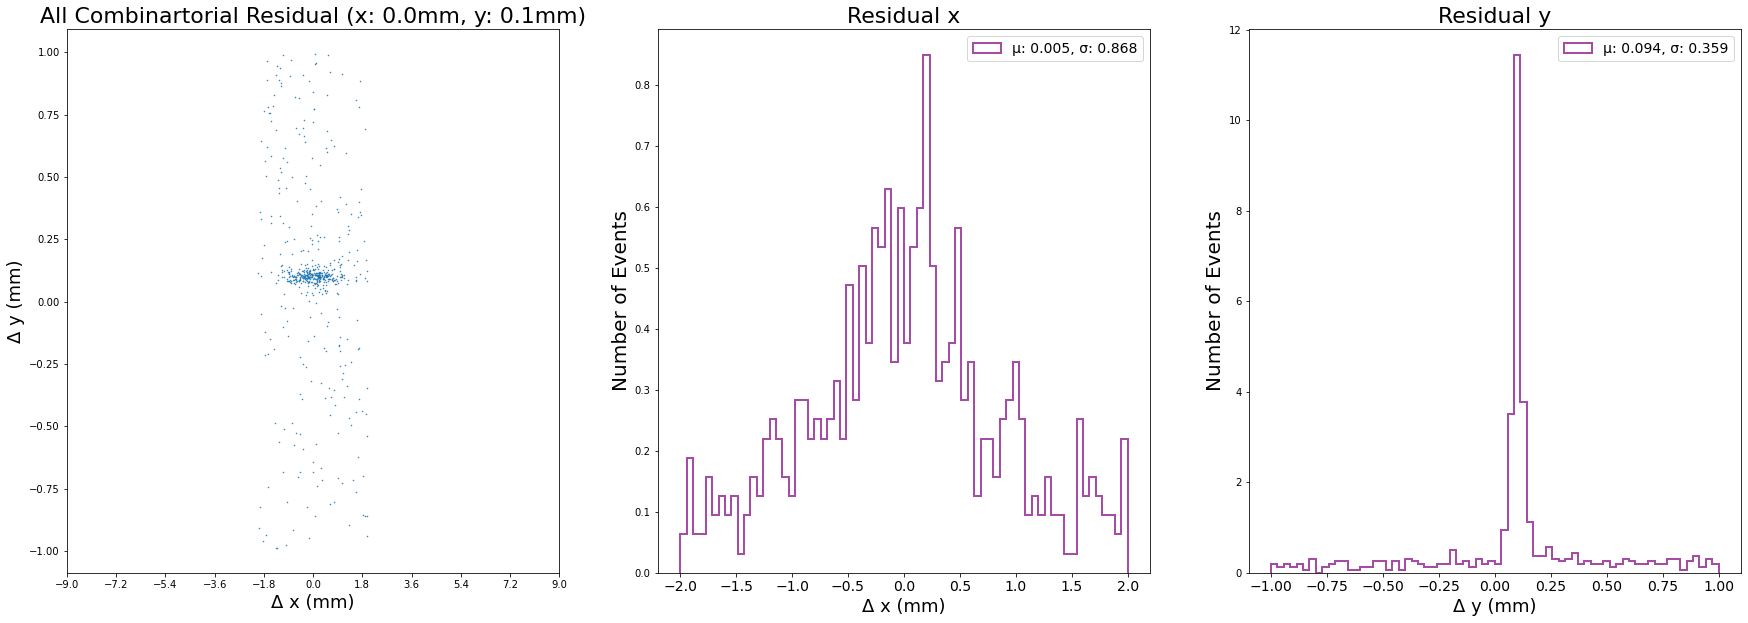

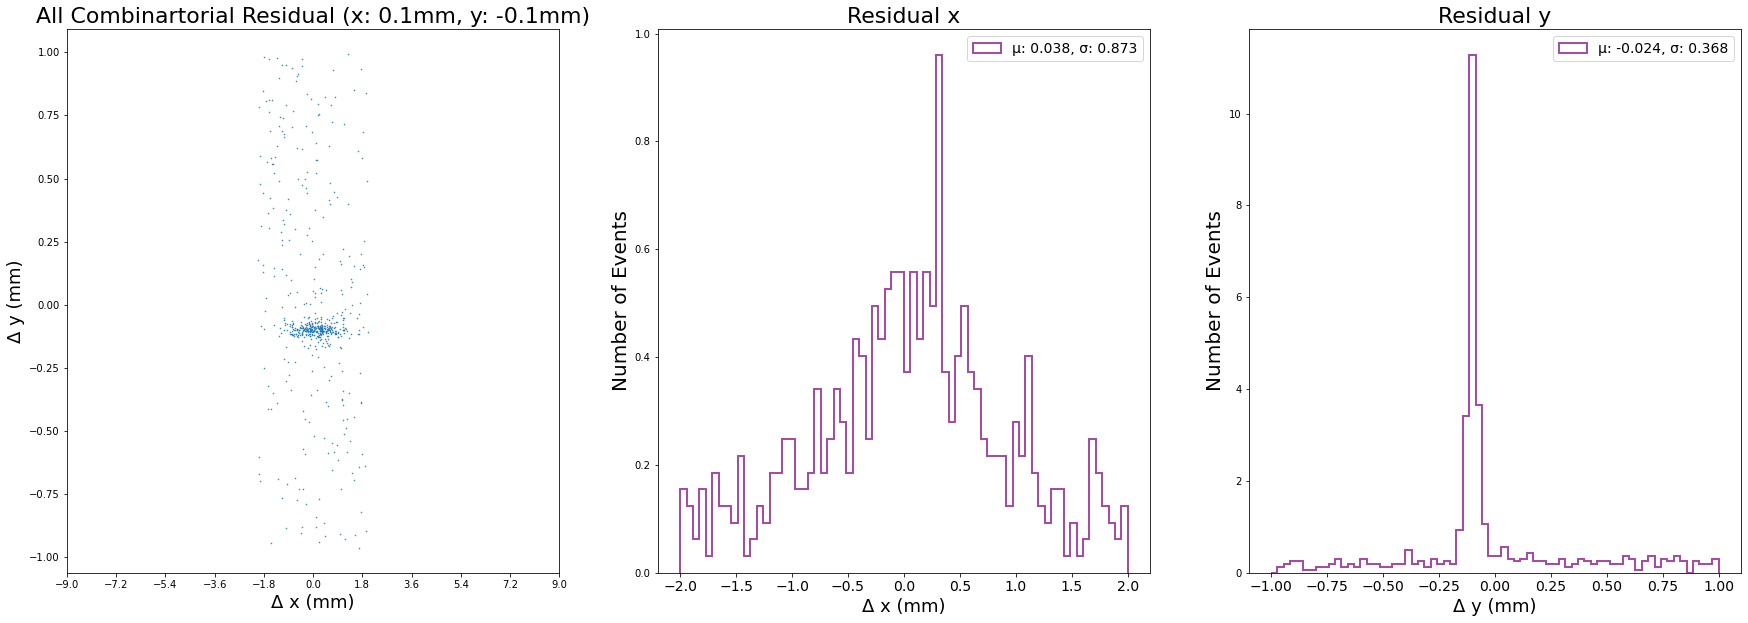

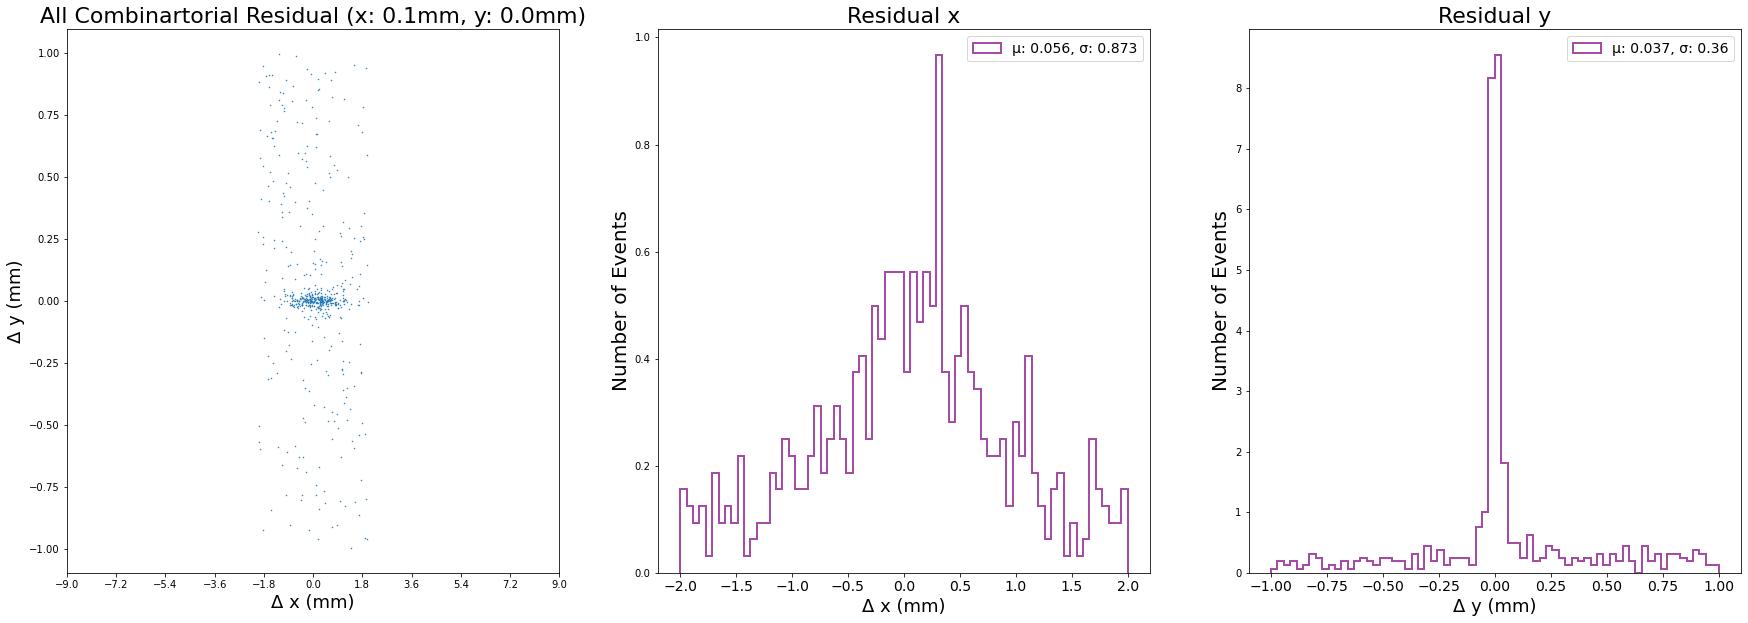

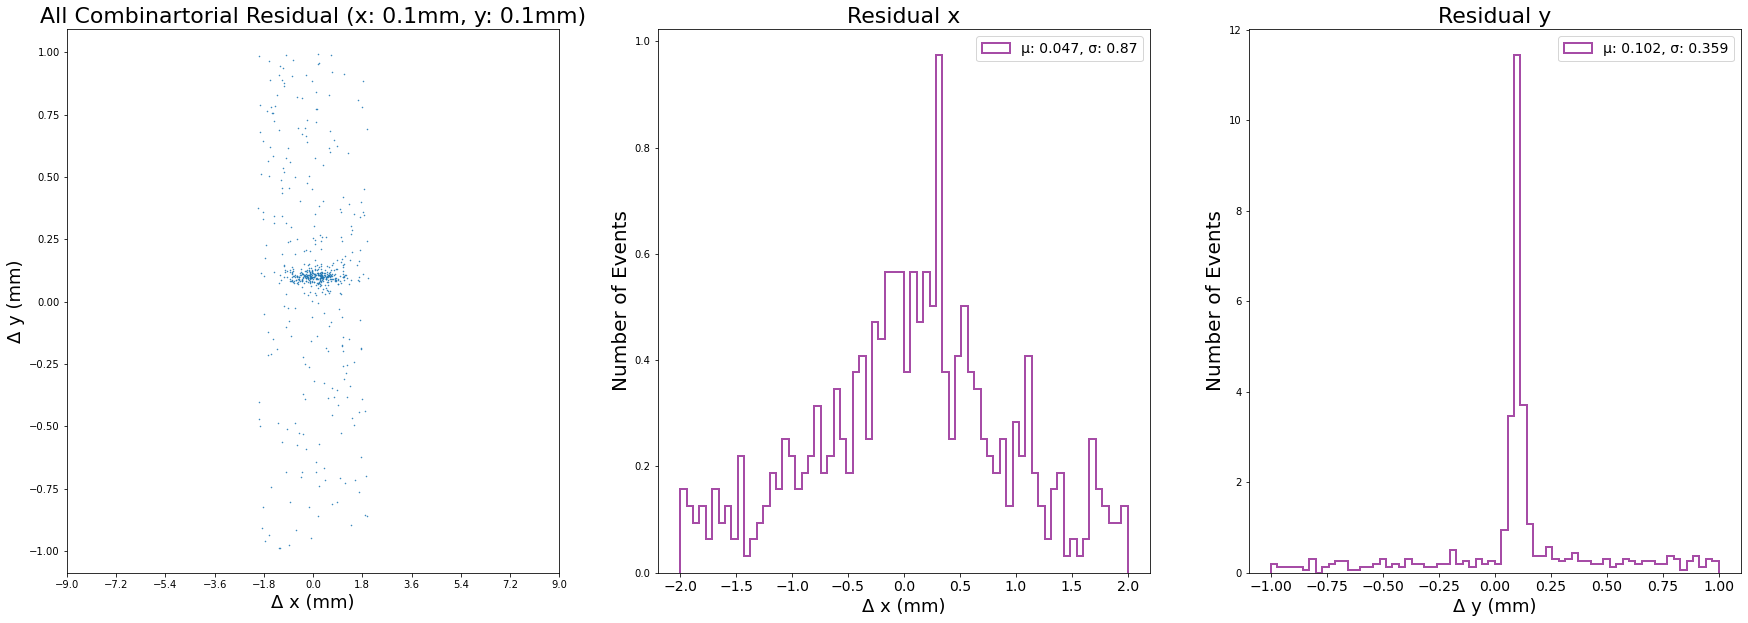

In [30]:
dx, dy = np.linspace(-0.1, 0.1, 3), np.linspace(-0.1, 0.1, 3)
# dx, dy = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)

for i in range(len(dx)):
    for j in range(len(dy)):
        dy_tmp = ((np.array(ift_y_pred) + dy[j]).reshape(len(ift_x_pred), 1) - np.array(emu.y_pred)).flatten()
        dx_tmp = ((np.array(ift_x_pred) + dx[i]).reshape(len(ift_x_pred), 1) - np.array(emu.x_pred)).flatten()
        dtx_tmp = ((np.array(ifttx)).reshape(len(ift_x_pred), 1) - np.array(emu['tx'])).flatten()
        dty_tmp = ((np.array(iftty)).reshape(len(ift_x_pred), 1) - np.array(emu['ty'])).flatten()
        
        m = pd.DataFrame({'x_res': dx_tmp, 'y_res': dy_tmp, 'tx_res': dtx_tmp, 'ty_res': dty_tmp})
        # m = m[(abs(m['x_res']) < 9) & (abs(m['y_res']) < 4) & (abs(m['ty_res']) < 0.1)]
        m = m[(abs(m['x_res']) < 2) & (abs(m['y_res']) < 1) & (abs(m['ty_res']) < 0.1)]


        plt.figure(figsize=(30, 10)) 

        dy_sel = m['y_res']
        dx_sel = m['x_res']
        
        plt.subplot(1, 3, 1)
        plt.scatter(dx_sel, dy_sel, marker='.', s=1)
        plt.xlabel(f'Δ x (mm)', fontsize=18)
        plt.ylabel(f'Δ y (mm)', fontsize=18)
        plt.title(f'All Combinartorial Residual (x: {round(dx[i], 2)}mm, y: {round(dy[j], 2)}mm)', fontsize=22)
        plt.xticks(np.linspace(-9, 9, 11), fontsize=10)

        plt.subplot(1, 3, 2)
        bin = np.linspace(-2, 2, 71)
        plt.hist(dx_sel, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple', label=f'µ: {round(np.mean(dx_sel), 3)}, σ: {round(np.std(dx_sel), 3)}')
        plt.title('Residual x', fontsize=22)
        plt.ylabel('Number of Events', fontsize=20)
        plt.xlabel(f'Δ x (mm)', fontsize=18)
        plt.xticks(fontsize=14)
        plt.legend(fontsize=14)

        plt.subplot(1, 3, 3)
        # bin = np.linspace(-0.25, 0.25, 71)
        bin = np.linspace(-1, 1, 71)
        plt.hist(dy_sel, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple', label=f'µ: {round(np.mean(dy_sel), 3)}, σ: {round(np.std(dy_sel), 3)}')
        plt.title('Residual y', fontsize=22)
        plt.ylabel('Number of Events', fontsize=20)
        plt.xlabel(f'Δ y (mm)', fontsize=18)
        plt.xticks(fontsize=14)
        plt.legend(fontsize=14)

        plt.show()

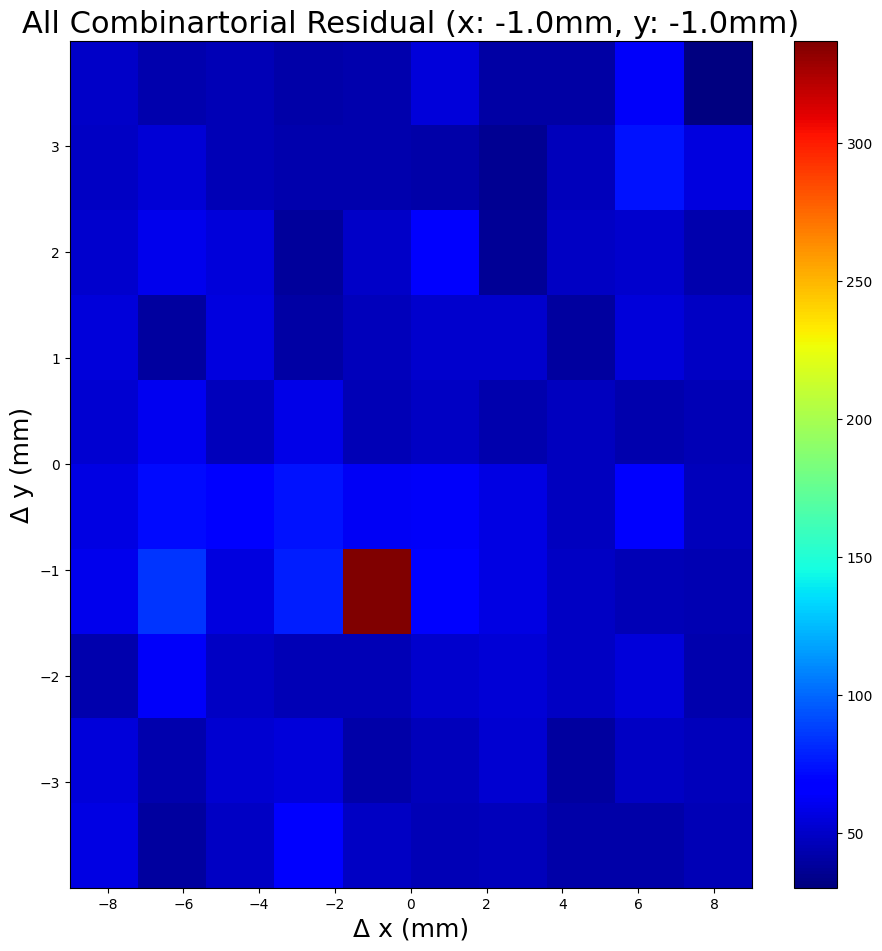

<Figure size 640x480 with 0 Axes>

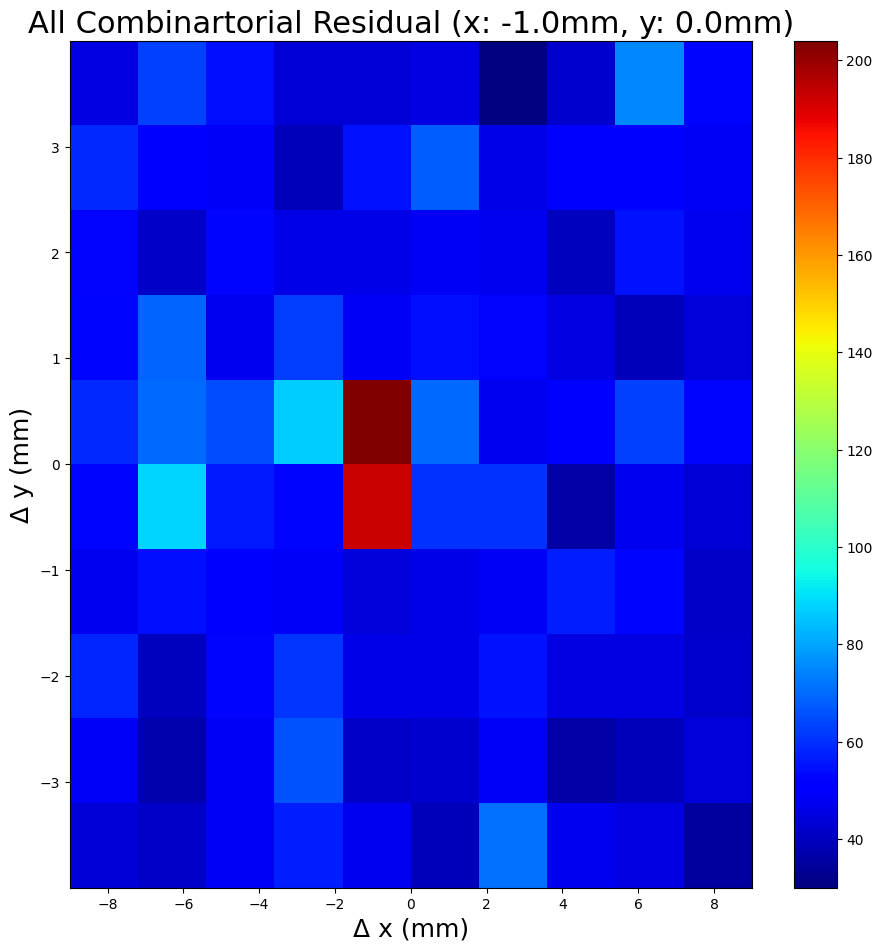

<Figure size 640x480 with 0 Axes>

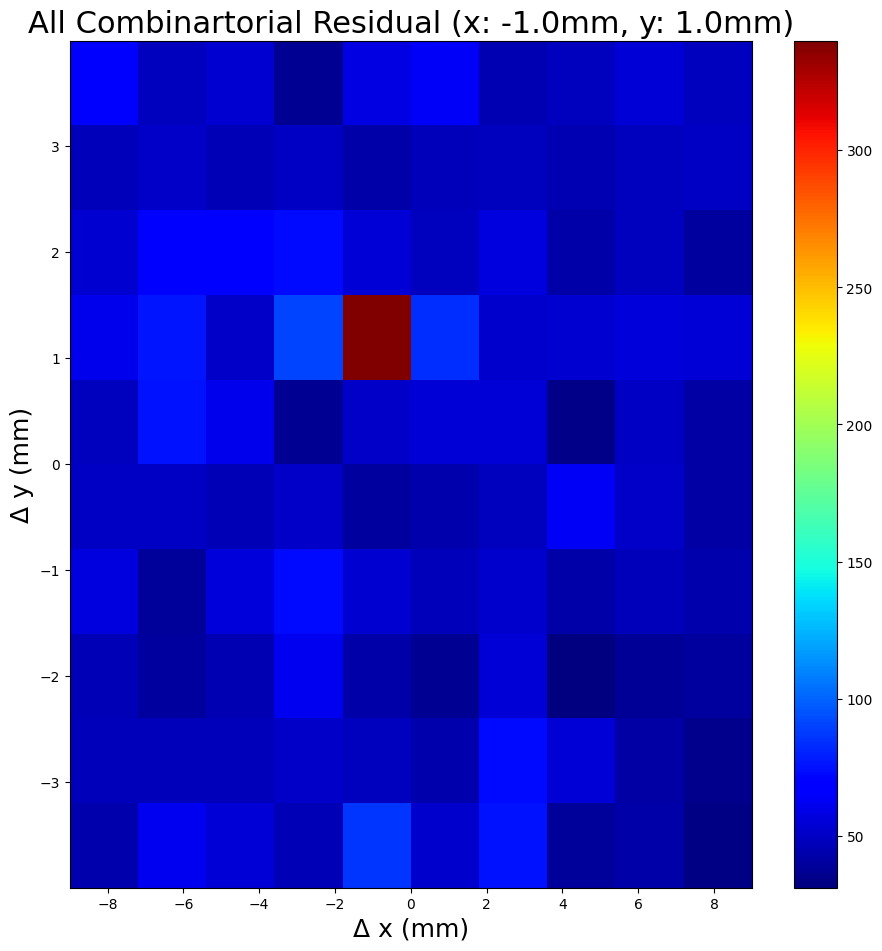

<Figure size 640x480 with 0 Axes>

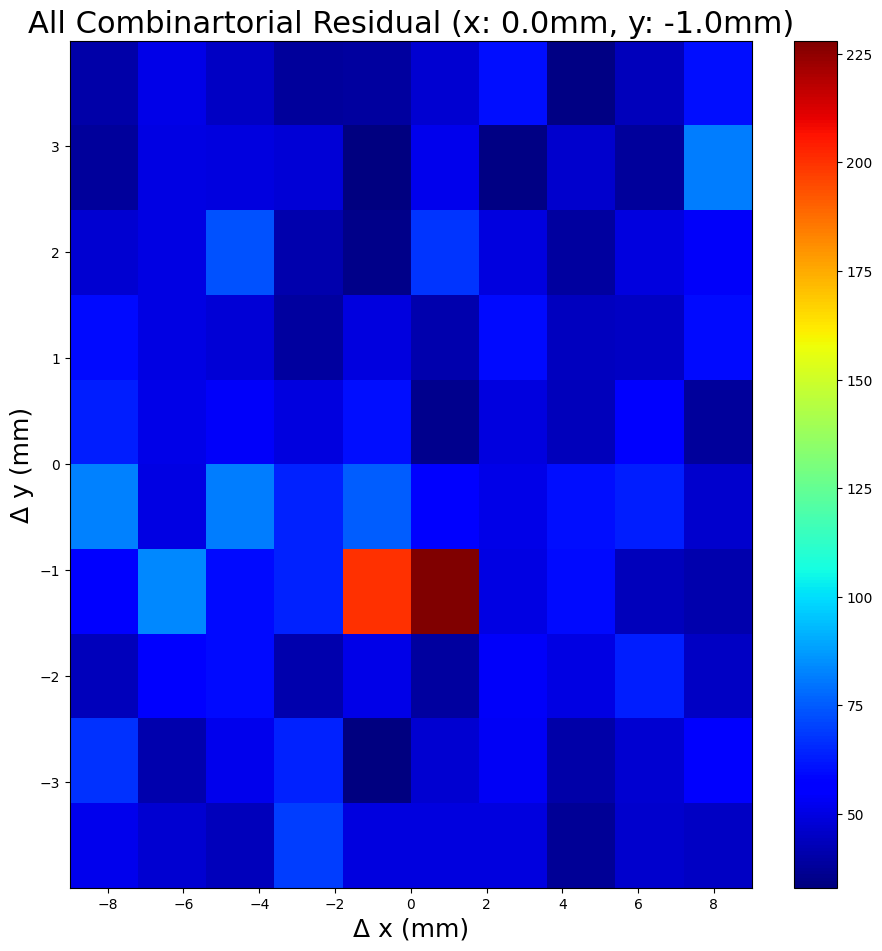

<Figure size 640x480 with 0 Axes>

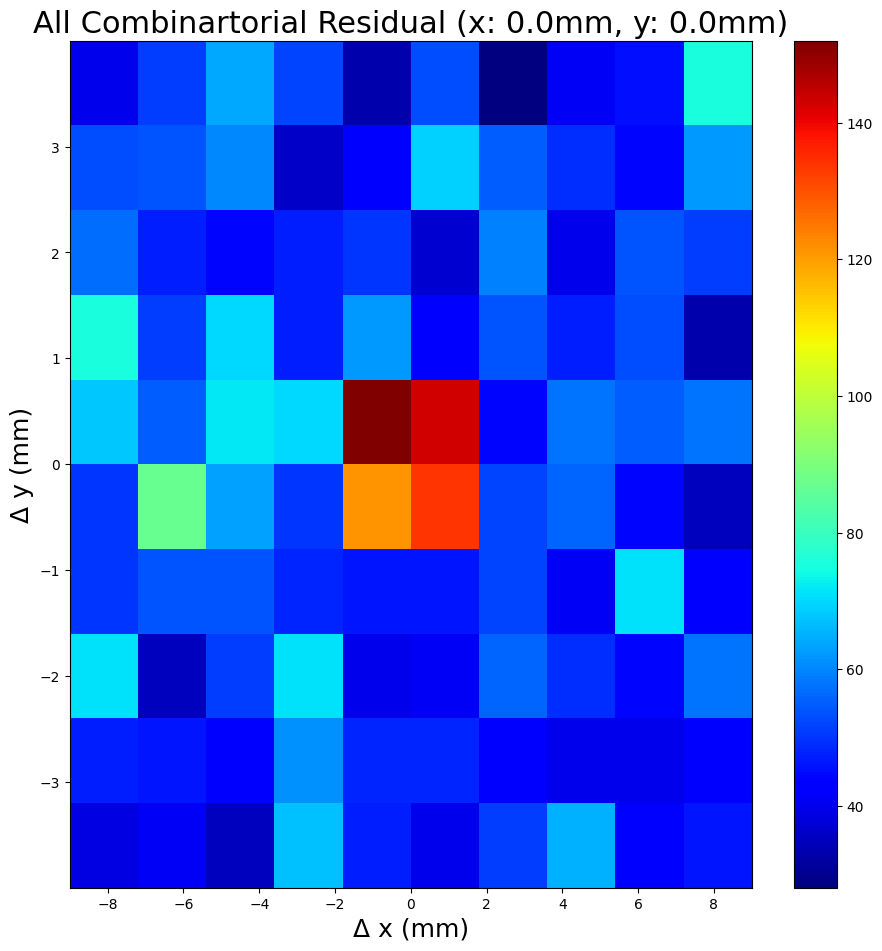

<Figure size 640x480 with 0 Axes>

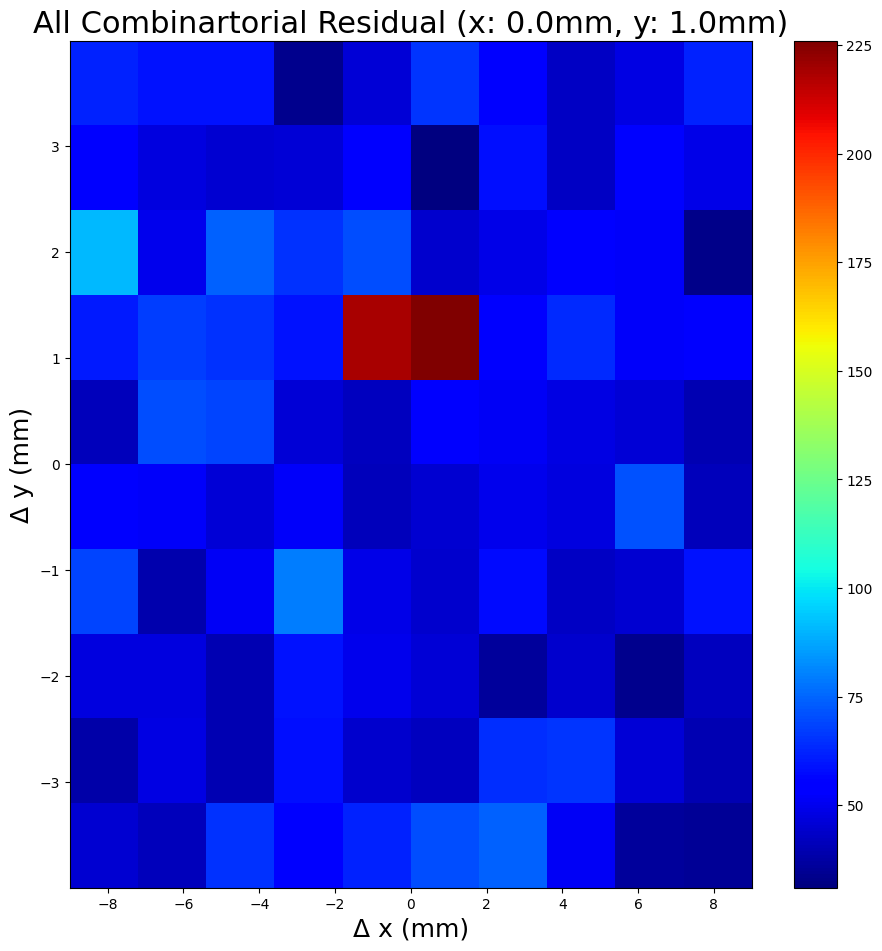

<Figure size 640x480 with 0 Axes>

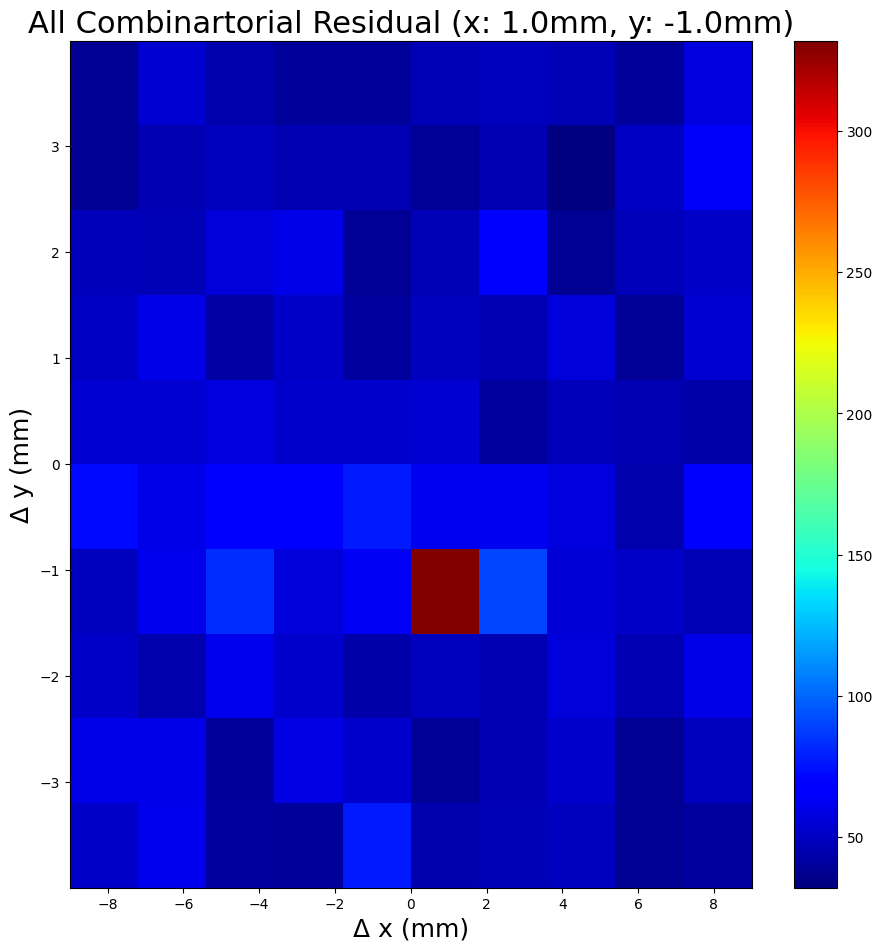

<Figure size 640x480 with 0 Axes>

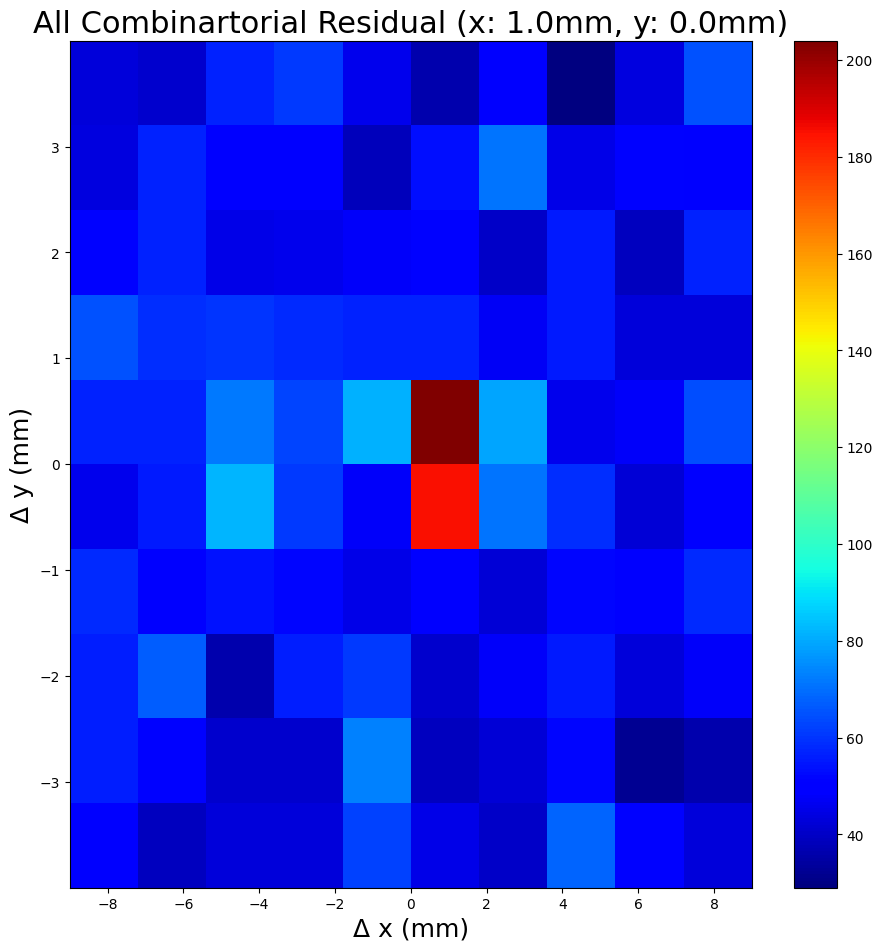

<Figure size 640x480 with 0 Axes>

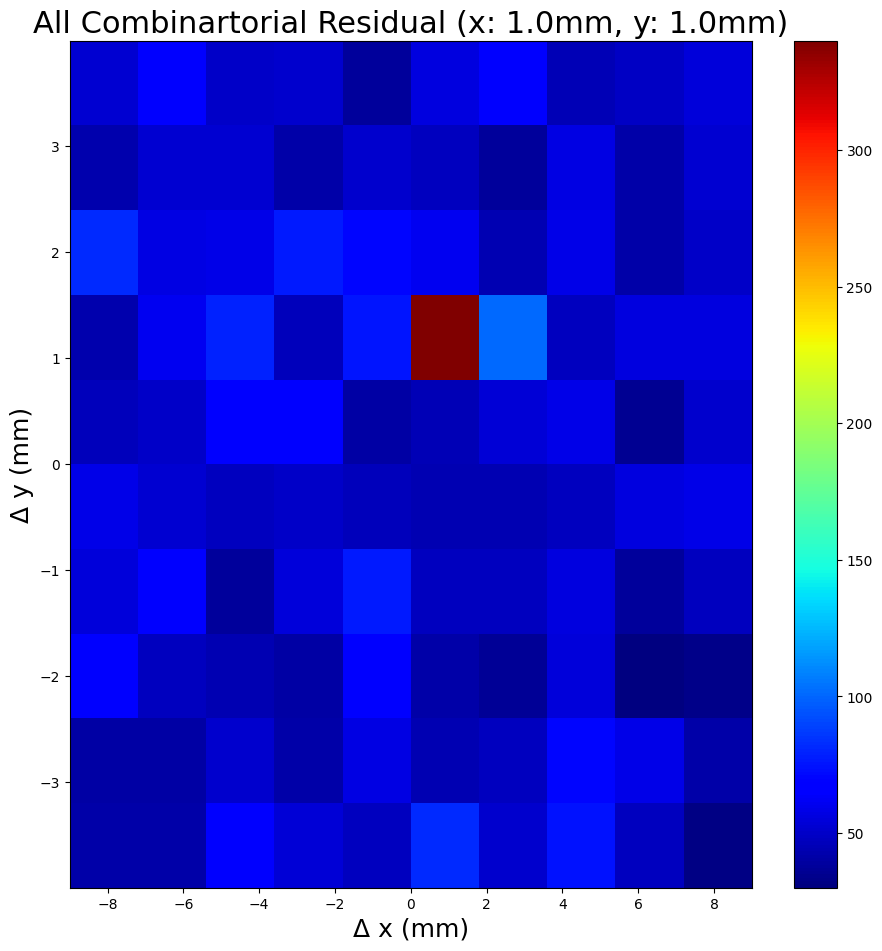

<Figure size 640x480 with 0 Axes>

In [ ]:
# Density Plot
dx, dy = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)
for i in range(len(dx)):
    for j in range(len(dy)):
        dy_tmp = ((np.array(ift_y_pred) + dy[j]).reshape(len(ift_x_pred), 1) - np.array(emu.y_pred)).flatten()
        dx_tmp = ((np.array(ift_x_pred) + dx[i]).reshape(len(ift_x_pred), 1) - np.array(emu.x_pred)).flatten()
        dtx_tmp = ((np.array(ifttx)).reshape(len(ift_x_pred), 1) - np.array(emu['tx'])).flatten()
        dty_tmp = ((np.array(iftty)).reshape(len(ift_x_pred), 1) - np.array(emu['ty'])).flatten()
        
        m = pd.DataFrame({'x_res': dx_tmp, 'y_res': dy_tmp, 'tx_res': dtx_tmp, 'ty_res': dty_tmp})
        m = m[(abs(m['x_res']) < 9) & (abs(m['y_res']) < 4)] # Can add ty cut to further increase the performance

        plt.figure(figsize=(11, 11)) 
        dy_sel = m['y_res']
        dx_sel = m['x_res']
        plt.hist2d(dx_sel, dy_sel, bins=(10, 10), cmap=plt.cm.jet)
        plt.xlabel(f'Δ x (mm)', fontsize=18)
        plt.ylabel(f'Δ y (mm)', fontsize=18)
        plt.title(f'All Combinartorial Residual (x: {round(dx[i], 2)}mm, y: {round(dy[j], 2)}mm)', fontsize=22)
        #plt.xticks(np.linspace(-9, 9, 11), fontsize=10)
        #plt.yticks(np.linspace(-.2, .2, 11), fontsize=10)
        plt.colorbar()

        plt.show()
        plt.clf()

# Minimum Chi2 Matching

In [129]:
x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295 # obtain these from truth match residual
def Chi2Match(chi2cut):
    Chi2 = []
    resx, resy, restx, resty = [], [], [], []
    sus = []
    for i in range(len(ift_x_pred)):
    #for i in range(1):
        emu_filter = emu[(emu.x_pred > ift_x_pred[i]-3*x_res/2) & (emu.x_pred < ift_x_pred[i]+3*x_res/2) & (emu.y_pred > ift_y_pred[i]-3*y_res/2) & (emu.y_pred < ift_y_pred[i]+3*y_res/2)]
        chi2 = np.sqrt((ift_x_pred[i]-emu_filter.x_pred)**2/(1.7211)**2 + (ift_y_pred[i]-emu_filter.y_pred)**2/(0.01811)**2 + (ifttx[i]-emu_filter.tx)**2/(0.01406)**2 + (iftty[i]-emu_filter.ty)**2/(0.00295)**2)
        Chi2.append(chi2)
        if np.min(chi2) < chi2cut: 
            min_num = np.where(chi2==np.min(chi2))[0][0]
            resx.append(ift_x_pred[i] - emu_filter.x_pred.iloc[min_num])
            resy.append(ift_y_pred[i] - emu_filter.y_pred.iloc[min_num])
            restx.append(ifttx[i] - emu_filter.tx.iloc[min_num])
            resty.append(iftty[i] - emu_filter.ty.iloc[min_num])

            if ift_evt[i] == emu_filter.eventID.iloc[min_num]: # Mark success if the event ID is matched
                sus.append(1)
            else: 
                sus.append(0)
    return sus, Chi2, resx, resy, restx, resty

sus, chi2, resx, resy, restx, resty = Chi2Match(20) # choose 20 as the mininum chi2 cut
sus_count = collections.Counter(sus)
print(sus_count[1])
print(sus_count[0]+sus_count[1])
print(len(resx))
print(f'Successfully matched percent {sus_count[1]/(sus_count[0]+sus_count[1]):.3e} %')

333
354
354
Successfully matched percent 9.407e-01 %


In [131]:
x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295 # obtain these from truth match residual

def Chi2Match(chi2cut):
    # Step 1: Calculate chi2 for all possible pairs
    pairs = []
    resx, resy, restx, resty = [], [], [], []
    sus = []

    chi2 = np.sqrt((ift_x_pred[:,np.newaxis]-emu.x_pred.values)**2/(1.7211)**2 + (ift_y_pred[:,np.newaxis]-emu.y_pred.values)**2/(0.01811)**2 + (ifttx[:,np.newaxis]-emu.tx.values)**2/(0.01406)**2 + (iftty[:,np.newaxis]-emu.ty.values)**2/(0.00295)**2)
    i_indices, j_indices = np.where(chi2 < chi2cut)
    pairs = list(zip(i_indices, j_indices, chi2[i_indices, j_indices]))

    # Step 2: Sort pairs by increasing values of chi2
    pairs.sort(key=lambda x: x[2])

    # Step 3: Select good matches without repeated tracks
    used_ift, used_emu = set(), set()

    while pairs:
        ift_index, emu_index, chi2 = pairs.pop(0)
        if ift_index not in used_ift and emu_index not in used_emu:
            if ift_evt[ift_index] == emu.eventID.iloc[emu_index]:
                sus.append(1)
            else:
                sus.append(0)
            used_ift.add(ift_index)
            used_emu.add(emu_index)
            resx.append(ift_x_pred[ift_index] - emu.x_pred.iloc[emu_index])
            resy.append(ift_y_pred[ift_index] - emu.y_pred.iloc[emu_index])
            restx.append(ifttx[ift_index] - emu.tx.iloc[emu_index])
            resty.append(iftty[ift_index] - emu.ty.iloc[emu_index])
    return sus, resx, resy, restx, resty

sus, resx, resy, restx, resty = Chi2Match(20)
sus_count = collections.Counter(sus)
print(sus_count[1])
print(sus_count[0]+sus_count[1])
print(f'Successfully matched percent {sus_count[1]/(sus_count[0]+sus_count[1]):.3e} %')

487
335
487
Successfully matched percent 6.879e-01 %


In [99]:
# x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295 # obtain these from truth match residual
# def Chi2Match(chi2cut):
#     resx, resy, restx, resty = [], [], [], []
#     sus = []
#     used_emu_idx = []
#     for i in range(len(ift_x_pred)):
#     #for i in range(1):
#         emu_filter = emu[(~emu.index.isin(used_emu_idx)) & (emu.x_pred > ift_x_pred[i]-3*x_res/2) & (emu.x_pred < ift_x_pred[i]+3*x_res/2) & (emu.y_pred > ift_y_pred[i]-3*y_res/2) & (emu.y_pred < ift_y_pred[i]+3*y_res/2)]
#         chi2 = np.sqrt(((ift_x_pred[i] + 0.1)-emu_filter.x_pred)**2/(1.7211)**2 + ((ift_y_pred[i] + 0.1)-emu_filter.y_pred)**2/(0.01811)**2 + (ifttx[i]-emu_filter.tx)**2/(0.01406)**2 + (iftty[i]-emu_filter.ty)**2/(0.00295)**2)
        
#         if np.min(chi2) < chi2cut: 
#             min_num = np.where(chi2==np.min(chi2))[0][0]
#             resx.append((ift_x_pred[i] + 0.1) - emu_filter.x_pred.iloc[min_num])
#             resy.append((ift_y_pred[i] + 0.1) - emu_filter.y_pred.iloc[min_num])
#             restx.append(ifttx[i] - emu_filter.tx.iloc[min_num])
#             resty.append(iftty[i] - emu_filter.ty.iloc[min_num])
#             used_emu_idx.append(emu_filter.index[min_num])  # add matched point to used_indices

#             if ift_evt[i] == emu_filter.eventID.iloc[min_num]: # Mark success if the event ID is matched
#                 sus.append(1)
#             else: 
#                 sus.append(0)
#     return sus, resx, resy, restx, resty 

# sus, resx, resy, restx, resty = Chi2Match(100) # choose 20 as the mininum chi2 cut
# sus_count = collections.Counter(sus)

# # print percent of successful matches
# print("Successfully matched percent", sus_count[1]/(sus_count[0]+sus_count[1]))

Successfully matched percent 0.9065934065934066


In [132]:
from lmfit.models import GaussianModel

def gauss_fit(data, min, max):
    data = np.array(data)
    data = data[(data > min) & (data < max)]
    npix = len(data)
    nbins = int(npix)
    n, bins = np.histogram(data, bins=nbins, density=True)
    n, bins = np.array(n), np.array(bins)
    # Generate data from bins as a set of points 
    bin_size = abs(bins[1]-bins[0])
    x =np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0, num=nbins,endpoint=True)
    y = n
    model = GaussianModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    mean = result.params['center'].value
    mean_err = result.params['center'].stderr
    stddev = result.params['sigma'].value
    stddev_err = result.params['sigma'].stderr
    return result, x, mean, mean_err, stddev, stddev_err


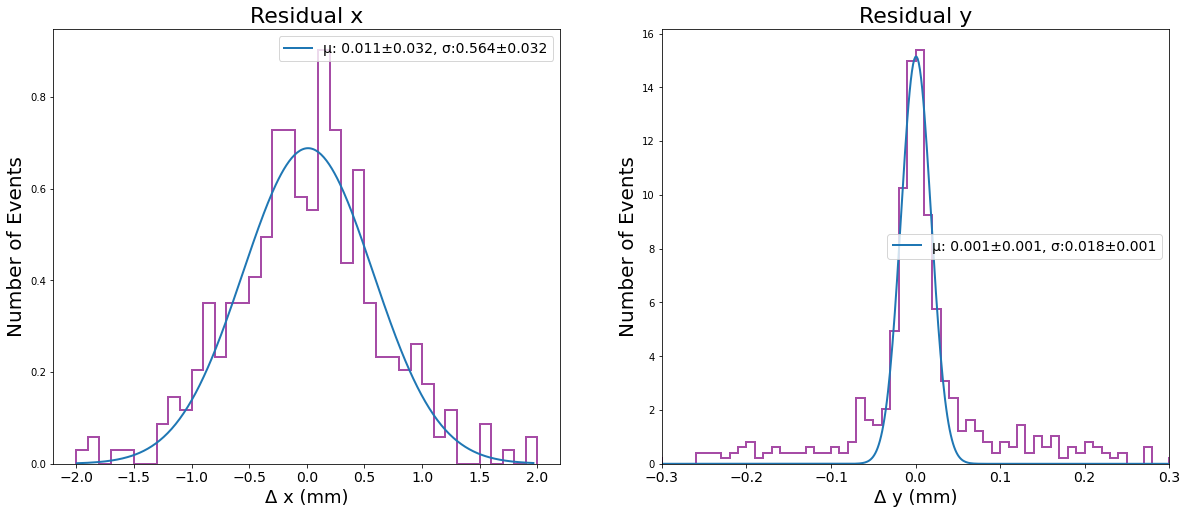

In [133]:
# plot x residual and y residual separately in subplots
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
bin = np.linspace(-2, 2, 41)
result, x, mean, mean_err, stddev, stddev_err = gauss_fit(resx, -2, 2)
plt.hist(resx, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple')
plt.plot(x, result.best_fit, linewidth=2, label=f'µ: {round(mean, 3)}±{round(mean_err, 3)}, σ:{round(stddev, 3)}±{round(stddev_err, 3)}')

plt.title('Residual x', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel(f'Δ x (mm)', fontsize=18)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
bin = np.linspace(-0.5, 0.5, 101)
result, x, mean, mean_err, stddev, stddev_err = gauss_fit(resy, -0.5, 0.5)
plt.hist(resy, bins=bin, alpha=0.7, histtype='step', linewidth=2, density=True, color='purple')
plt.plot(x, result.best_fit, linewidth=2, label=f'µ: {round(mean, 3)}±{round(mean_err, 3)}, σ:{round(stddev, 3)}±{round(stddev_err, 3)}')
plt.title('Residual y', fontsize=22)
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel(f'Δ y (mm)', fontsize=18)
plt.xlim(-0.3, 0.3)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Study of optimal minimum chi2 cut value

In [28]:
x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295
def long(chi2cut):
    Chi2 = []
    resx, resy, restx, resty = [], [], [], []
    sus = []
    for i in range(len(ift_x_pred)):
    #for i in range(1):
        emu_filter = emu[(emu.x_pred > ift_x_pred[i]-3*x_res/2) & (emu.x_pred < ift_x_pred[i]+3*x_res/2) & (emu.y_pred > ift_y_pred[i]-3*y_res/2) & (emu.y_pred < ift_y_pred[i]+3*y_res/2)]
        chi2 = np.sqrt((ift_x_pred[i]-emu_filter.x_pred)**2/(1.7211)**2 + (ift_y_pred[i]-emu_filter.y_pred)**2/(0.01811)**2 + (ifttx[i]-emu_filter.tx)**2/(0.01406)**2 + (iftty[i]-emu_filter.ty)**2/(0.00295)**2)
        
        if np.min(chi2) < chi2cut: 
            min_num = np.where(chi2==np.min(chi2))[0][0]
            resx.append(ift_x_pred[i] - emu_filter.x_pred.iloc[min_num])
            resy.append(ift_y_pred[i] - emu_filter.y_pred.iloc[min_num])
            restx.append(ifttx[i] - emu_filter.tx.iloc[min_num])
            resty.append(iftty[i] - emu_filter.ty.iloc[min_num])

            if ift_evt[i] == emu_filter.eventID.iloc[min_num]:
                sus.append(1)
            else: 
                sus.append(0)
        

    co = collections.Counter(sus)
    tmp.append(co[1]/(co[0]+co[1]))
    tm.append(co[1])
    mm.append(co[0])

tmp = []
tm, mm = [], []
for i in tqdm(np.linspace(1, 40, 40)):
    long(i)

100%|██████████| 40/40 [02:28<00:00,  3.71s/it]


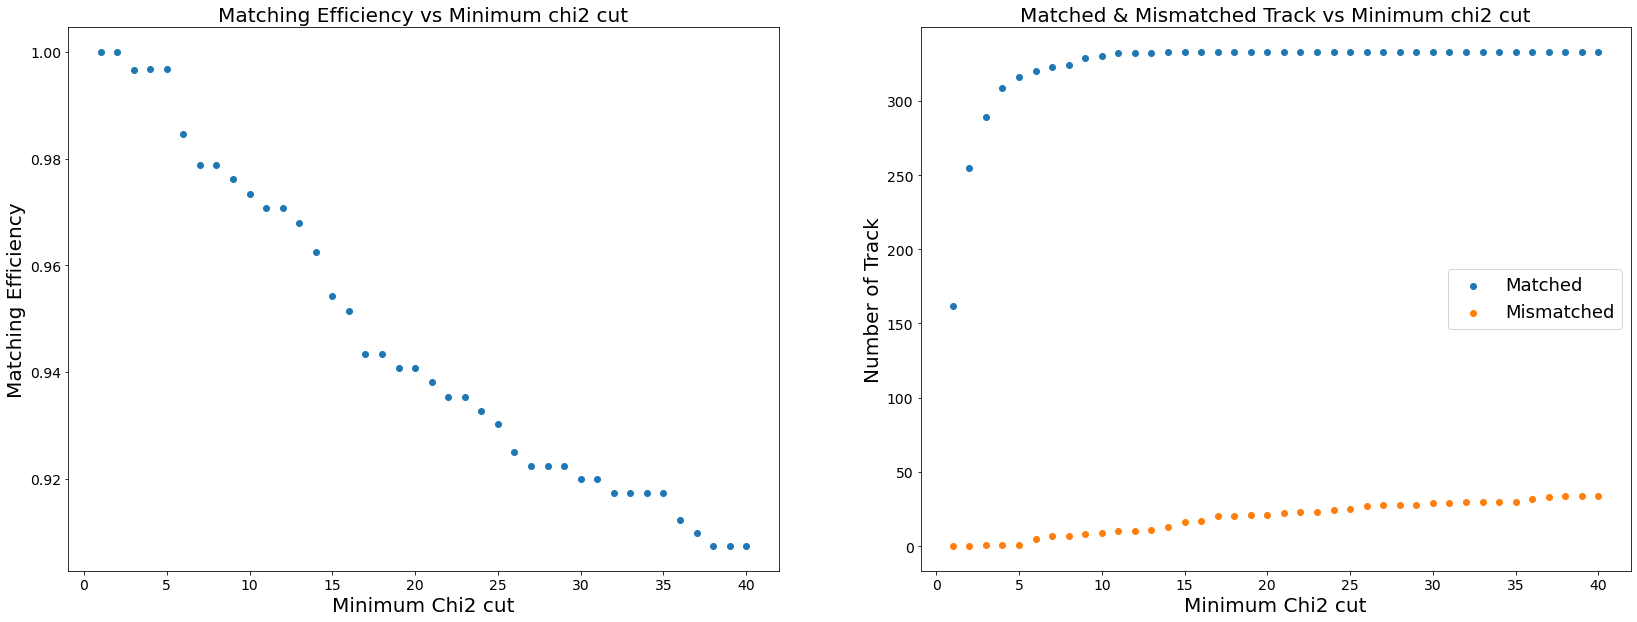

In [29]:
plt.figure(figsize=(28, 10))
plt.subplot(1, 2, 1)
c2 = np.linspace(1, 40, 40)
plt.scatter(c2, tmp)
plt.ylabel('Matching Efficiency', fontsize=20)
plt.xlabel('Minimum Chi2 cut', fontsize=20)
plt.title('Matching Efficiency vs Minimum chi2 cut', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(c2, tm, label='Matched')
plt.scatter(c2, mm, label='Mismatched')
plt.ylabel('Number of Track', fontsize=20)
plt.xlabel('Minimum Chi2 cut', fontsize=20)
plt.title('Matched & Mismatched Track vs Minimum chi2 cut', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)